# Reconstrucción de una imagen de un medio poroso en 2D con una red neuronal en un autómata celular implementada paso a paso en Python sin usar bibliotecas de Machine Learning como Keras, Tensorflow, Pytorch, etc.

El presente proyecto se basa en el trabajo original de Daniel Teniente (https://github.com/danielTeniente/ia-projects/tree/main/ANN)


Videotutorial: https://www.youtube.com/watch?v=MN96NzKzF0Q&ab_channel=TranquilRelaxation



El estado de las celdas (o pixeles) del autómata celular (la imagen) evoluciona autoorganizándose hasta llegar a un patrón estable donde logre reconstruir la imagen de un medio poroso en 2D con una red neuronal diseñada e implementada en Python paso a paso para entender lo mejor posible todo el proceso sin usar bibliotecas sofisticadas como Keras, tensorflow, Pytorch, etc.

Primero se importan las bibliotecas necesarias.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

# Diseño de la red neuronal

Definimos una función llamada "create_network" para crear una red neuronal.

El grafo es representado mediante una lista de listas (matriz) que contiene los vecinos de cada nodo. 

Por defecto se asignan 100 nodos, pero pueden ser más y la probabilidad de conexión será 0.5 por defecto, para que sea como el proceso binario de lanzar una moneda.

Además, se necesita de otra matriz para los pesos de las conexiones entre los nodos. 

In [2]:
# El grafo se representa con una matriz 
# Cada fila guarda los vecinos del nodo actual
# La conexión es aleatoria

def create_network(num_nodes = 100, p_conection=0.5):
    network = []
    weights_matrix = []
    for _ in range(num_nodes):
        neighbors = bernoulli.rvs(p_conection, size=num_nodes)    
        neighbors = np.where(neighbors==1)[0]
        # Conexiones de la neurona
        network.append(neighbors)
        # Matriz de pesos de las conexiones
        weights_matrix.append(np.zeros(len(neighbors)))
                
    return network,weights_matrix

Se modifican los pesos para que la red neuronal pueda aprender el patrón de la imagen, utilizando el aprendizaje Hebbiano, por lo que si las neuronas se activan juntas, la conexión se refuerza.

In [3]:
# Aprendizaje del patrón de la imagen dado una red y el tipo de aprendizaje
def learn(network,weights_matrix,pattern):
    # Se recorren los vecinos de cada nodo
    for i,neighbors in enumerate(network):
        # Aprendizaje Hebbiano (Hebbian Learning)
        weights_matrix[i] += pattern[neighbors] * pattern[i]

Una vez que se obtienen la red neuronal y los pesos, se necesita una función para que la red evolucione hacia el patrón que se le enseñó. Esto se realiza tomando el valor de cada vecino de la neurona para multiplicarlo por su peso correspondiente. Al final se suman estos resultados.

In [5]:
# Las neuronas utilizarán los pesos para reconstruir la imagen
def evolve(network, weights_matrix, current_state):
    new_state = np.zeros(len(current_state))
    # Se recorren los vecinos de cada nodo
    for i,neighbors in enumerate(network):
        # índicees de los vecinos
        # cambio de estado
        new_state[i] = sum(current_state[neighbors]*weights_matrix[i])
        if(new_state[i]<0):
            new_state[i] = -1
        else:
            new_state[i] = 1
    return new_state


# Cargar la imagen que se desea replicar

"imread" es una función de la biblioteca OpenCV en Python que se utiliza para leer una imagen (en este caso llamada "slide_156.png", la cual está en formato PNG) y almacenarla en forma de matriz NumPy. El segundo argumento, 0, es para leer la imagen en escala de grises.

In [9]:
# Se lee la imagen que se desea replicar
img = cv2.imread("slide_156.png",0)

# Procesamiento de binarización de la imagen para usarse en la red neuronal

"imshow" es una función de la biblioteca Matplotlib en Python que se utiliza para mostrar una imagen. 

Aquí, "img" es la matriz de la imagen que se quiere visualizar y 'gray' indica que queremos mostrar la imagen en escala de grises, utilizando una representación de mapa de colores en escala de grises, donde los valores más bajos (más oscuros) se representan con tonos más oscuros de gris, y los valores más altos (más claros) se representan con tonos más claros de gris.

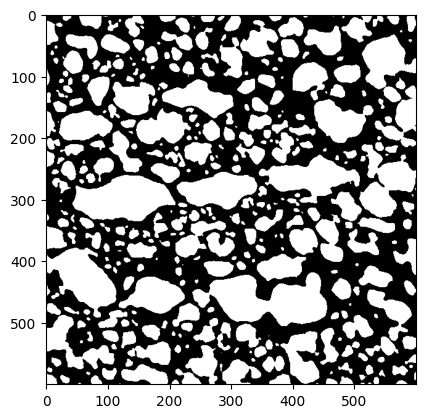

In [12]:
# Se visualiza la imagen que se cargó previamente.
plt.imshow(img, 'gray') # en escala de grises
#plt.imshow(img) # con colores preasignados por matplotlib

"shape" es un atributo de una matriz NumPy que devuelve una tupla que representa las dimensiones de la matriz. 

Para una imagen, esta tupla generalmente tiene tres valores: altura, anchura y número de canales de color.

    Si "img" es una imagen en escala de grises, la tupla tendrá dos elementos: (altura, anchura).
    Si "img" es una imagen en color, la tupla tendrá tres elementos: (altura, anchura, canales).

Por ejemplo, si "img" es una imagen en color de 640x480 píxeles, img.shape devolverá (480, 640, 3), lo que significa que tiene una altura de 480 píxeles, una anchura de 640 píxeles y tres canales de color (normalmente rojo, verde y azul o RGB por sus siglas en inglés (Red, Green, Blue)). 

Por otro lado, si "img" es una imagen en escala de grises, la tupla sería (480, 640), indicando solo altura y anchura.

In [13]:
img.shape

(600, 600)

Se redimensiona la imagen para que no utilizar demasiados recursos computacionales. 

Se recomienda experimentar cambiando el ancho y alto de la imagen para observar el uso de los recursos computacionales como el porcentaje de uso de la RAM, CPU, GPU y tiempo de compilación, conforme se utiliza una imagen cada vez más grande.

La función "resize" de OpenCV cambia el tamaño de las imágenes.

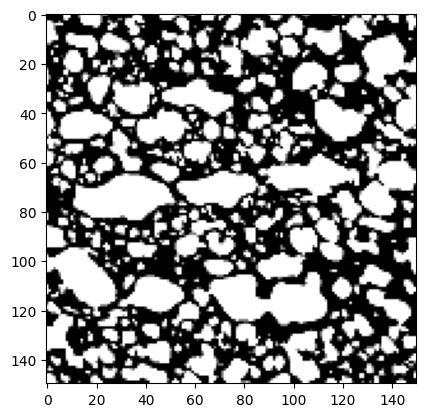

In [14]:
# Redimensiona la imagen representada por la matriz "img" a una nueva dimensión de 150x150 píxeles.
img = cv2.resize(img,(150,150))

# mostramos la imagen redimensionada
plt.imshow(img,'gray')

Binarización de la imagen:

 La función "mean()" calcula el valor medio de todos los píxeles en la imagen. Este valor medio se utiliza a menudo como un umbral para aplicar operaciones de umbralización en imágenes. Es decir, los píxeles con intensidad mayor que el umbral se asignan a un valor específico (generalmente 255 o blanco), mientras que los píxeles con intensidad menor o igual al umbral se asignan a otro valor (generalmente 0 o negro). Pero también se puede utilizar el método de Otsu para calcular el valor del umbral, el cual está implementado en "OpenCV".

In [15]:
 # Se calcula el umbral (threshold) con el promedio de intensidad de los píxeles de la imagen "img"
threshold = img.mean()

# visualizamos el valor calculado
threshold

124.98422222222223

Se realiza una operación de umbralización en la imagen:

* Estableciendo a cero todos los píxeles cuyos valores son menores al umbral calculado previamente.

  "np.where(img < threshold)" crea una matriz de índices booleanos donde los elementos son True si el valor correspondiente en "img" es menor que el umbral, y False de lo contrario.

* Estableciendo a uno todos los píxeles cuyos valores son mayores o iguales al umbral calculado previamente.

  "np.where(img >= threshold)" crea una matriz de índices booleanos donde los elementos son True si el valor correspondiente en "img" es mayor o igual que el umbral, y False de lo contrario.

In [16]:
# Se seleccionan los elementos en la matriz "img" donde los valores son menores que el umbral calculado previamente y se les asigna una valor igual a cero.
img[np.where(img<threshold)]= 0

# Se seleccionan los elementos en la matriz "img" donde los valores son mayores o iguales que el umbral calculado previamente y se les asigna una valor igual a uno.
img[np.where(img>=threshold)]= 1

 Se convierte la matriz de la imagen "img" a un tipo de datos de entero de 8 bits con signo (int8). Es decir, cada valor de píxel en la imagen será representado por un número entero de 8 bits, con un rango de valores de -128 a 127, en lugar de 0 a 255.

Esta conversión puede ser útil en algunas operaciones específicas donde se requieren datos en este formato particular, como la optimización de uso de memoria o para ciertos cálculos numéricos. Sin embargo, es importante tener en cuenta que al convertir a un tipo de datos de menor precisión, se puede perder información de la imagen, especialmente si los valores originales de píxeles están en un rango mayor que el soportado por int8.


In [17]:
# Conversión de la matriz de la imagen "img" a un tipo de datos de entero de 8 bits con signo (int8).
img = np.array(img, dtype='int8')

# Se seleccionan los elementos en la matriz "img" donde los valores son igual a 0 y se les reasigna el valor -1.
img[np.where(img==0)]=-1 

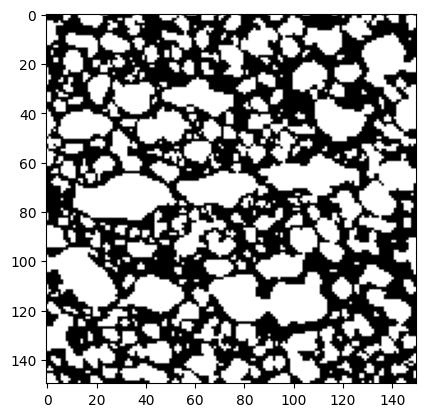

In [18]:
# Se muestra la imagen procesada
plt.imshow(img,'gray')

Se calcula el promedio de la imagen procesada, la cual ahora tiene valores -1 y 1.

In [19]:
# Se calcula el promedio de la imagen procesada.
img.mean()

0.016888888888888887

Se aplana la imagen. Es decir, se redimensiona la matriz "img" para crear un nuevo arreglo unidimensional que contiene los elementos de "img" en el orden en que aparecen en la matriz original, y de esta manera, este vector ya pueda ser aprendido por la red neuronal.

In [20]:
# Se redimensiona la matriz "img" para que tenga la misma cantidad total de elementos que la matriz "img".
flat_img = np.resize(img,img.size)

# Observamos la forma de la imagen aplanada
flat_img.shape

## Aprender el patrón

Se crea una nueva red neuronal llamada "network" y su matriz de pesos "weigths_matrix", llamando la función "create_network" implementada previamente en las primeras líneas de este códdigo, y asignando un valor a sus argumentos:

* num_nodes = longitud del vector unidimensional "flat_img", contiene los elementos de "img" en el orden en que aparecen en la matriz original.

                 La función "len()" regresa la longitud del argumento.

* p_conection = probabilidad de que la célula (pixel) se conecte con alguno de sus vecinos.

In [21]:
# Se crea una nueva red neuronal llamada "network"
network,weights_matrix = create_network(num_nodes=len(flat_img),p_conection=0.3)

Se imprime el tamaño de la red neuronal "network"

In [22]:
# imprime el tamaño de la red
len(network)

22500

Mediante el método "learn()" definido al principio del código, le pedimos a la red neuronal "network" que conforme la matriz de pesos "weights_matrix" definida anteriormente, aprenda el patrón de la imagen plana "flat_img".

In [23]:
# Aprendizaje del patrón de la imagen
learn(network,weights_matrix,flat_img)

# Probar el aprendizaje de la red neuronal

Se introduce ruido en la imagen para ver si la red neuronal puede reconstruirla.

In [27]:
# Se hace una copia de la imagen aplanada "flat_img" y la llamamos "random_img"
random_img = flat_img.copy()


La función "bernoulli.rvs(p, size)" de SciPy genera muestras de una distribución de Bernoulli con probabilidad de éxito "p".

    Donde: 
    
    "p" es la probabilidad de éxito de un solo ensayo de Bernoulli.

    "size" es el número de muestras que deseas generar.

Generaramos una serie de muestras de una distribución de Bernoulli con una probabilidad de éxito del 50%, y tamaño de la muestra igual a la longitud de la matriz de la copia de la imagen aplanada "random_img". Cada muestra sería un valor binario (0 o 1) que representa el resultado de un ensayo de Bernoulli independiente.

In [28]:
# Generaramos una serie de muestras de una distribución de Bernoulli con una probabilidad de éxito del 50%,
# y tamaño de la muestra igual a la longitud de la matriz de la copia de la imagen aplanada "random_img".
noise = bernoulli.rvs(0.5, size=len(random_img))    

Se aplica ruido a la imagen representada por la matriz "random_img", seleccionando los elementos en la matriz "random_img" donde los valores en la matriz noise son iguales a 1, y cambiándolos por -1.

"np.where(noise==1)" crea una matriz de índices booleanos donde los elementos son True si el valor correspondiente en la matriz noise es igual a 1, y False de lo contrario.

In [29]:
# Aplicamos ruido a la imagen 
random_img[np.where(noise==1)]=-1

In [30]:
# Redimensionamos la imagen con ruido para que sea del mismo ancho y alto que la imagen que se desea replicar
noise_img = np.resize(random_img,img.shape)

# Observamos las dimensiones de la imagen con ruido
noise_img.shape

(150, 150)

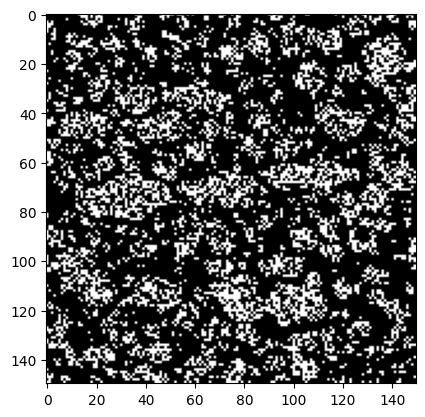

In [31]:
# Se visualiza la imagen con ruido en escala de grises
plt.imshow(noise_img, 'gray')

La red neuronal "network" genera los valores de matriz de la réplica de la imagen original, a partir de la matriz de la imagen ruidosa "random_img" y considerando la matriz de pesos "weights_matrix", mediante el método "evolve" definido al principio del código.

In [34]:
# Generamos la matriz de la imagen replicada a partir de la imagen con ruido
new_state = evolve(network, weights_matrix, random_img)

# Observamos las dimensiones de la matriz de la imagen generada por la red neuronal, la cual está todavía "aplanada"
new_state.shape

(22500,)

Visualizamos la imagen generada por la red neuronal

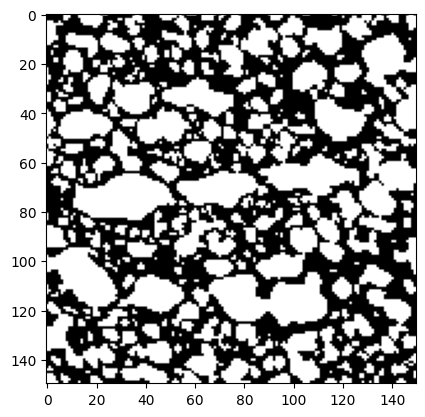

In [36]:
# Redimensionamos la imagen generada por la red neuronal, al mismo tamaño de la imagen original que deseamos replicar.
new_img = np.resize(new_state,img.shape)

# Visualizamos la imagen generada "new_img", ya redimensionada, en escala de grises.
plt.imshow(new_img, 'gray')

In [37]:
# Observamos las dimensiones de la imagen generada ya redimensionada
new_img.shape

(150, 150)

# Comparación entre la imagen reconstruida y la imagen original

Se define una función para comparar cuantitativamente la imagen reconstruida con la imagen original, multiplicando los valores de cada vector, dado que gracias a la binarización, los vectores sólo tienen dos valores: 1 y -1, así que al multiplicar los valores, si son iguales, sumarán y si son diferentes, restarán. Después, se divide la suma para el total de nodos y se multiplica por 100 para finalmente obtener el porcentaje de pixeles con valores iguales.

In [38]:
# Se define la función de comparación
def compare(original,result):
    return sum(original*result)/len(original)*100

In [39]:
# Se compara las matrices de ambas imágenes, la original y la reconstruida
# Si el resultado es 100, entonces la reconstrucción fue perfecta.
compare(flat_img, new_state)

100.0

# Probemos con otra imagen y veamos si la red puede aprender nuevos patrones

Ingresamos una imagen diferente y la procesamos para que pueda ser aprendida por la red neuronal.

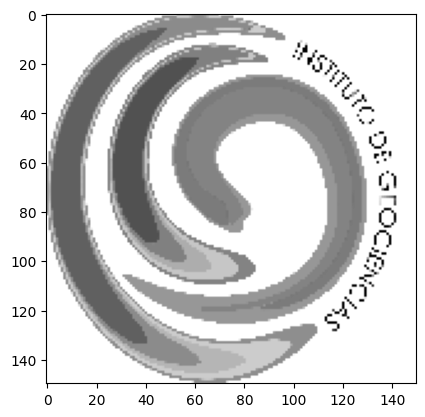

In [41]:
# Leemos una imagen nueva, en escala de grises con el segundo argumento "0" de la función "imread" de "OpenCV".
logo = cv2.imread("Instituto_de_Geociencias.png", 0)

# Redimensionamos la nueva imagen "logo" para que sea fácilmente tratada por la red neuronal.
logo = cv2.resize(logo, (150, 150))

# Visualizamos la imagen, en escala de grises con el segundo argumento "gray" de la función "imshow" de "Matplolib".
plt.imshow(logo,'gray')

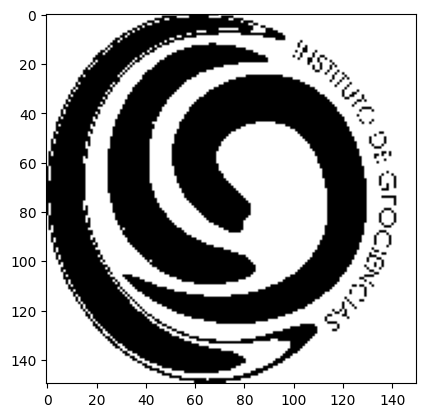

In [44]:
# Calculamos el umbral (threshold) para binarizar la imagen, mediante el promedio del valor de todos los pixeles. 
threshold = logo.mean()

# Se asignan 0 y 1 dependiendo el valor de cada pixel en comparación con el valor del umbral (threshold).
logo[np.where(logo < threshold)]= 0
logo[np.where(logo >= threshold)]= 1

# Cambiamos el tipo de datos para admitir -1
logo = np.array(logo, dtype='int8')

# Seleccionamos los pixeles cuyo valor sea 0 y les reasignamos un valor -1
logo[np.where(logo == 0)]=-1 

# Visualizamos la imagen 
plt.imshow(logo, 'gray') # en escala de grises
#plt.imshow(logo) # a colores preasignados por matplotlib

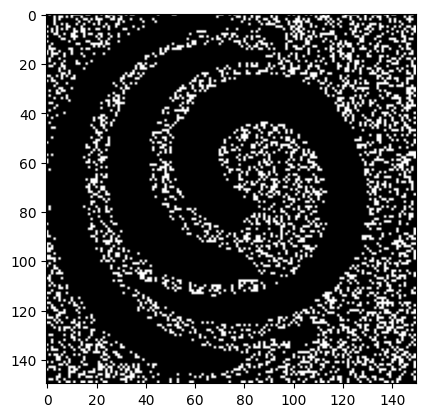

In [46]:
# Aplanamos la imagen para que todos los valores de los pixeles de la matriz de la imagen queden en un solo vector
flat_logo = np.resize(logo,logo.size)


# Le pedimos a la red que aprenda el patrón de la nueva imagen ya procesada y aplanada
learn(network,weights_matrix,flat_logo)

# Creamos una imagen con ruido, primero creando una copia de la misma ya aplanada
random_logo = flat_logo.copy()

# Le agregamos ruido a la copia aplanada
noise = bernoulli.rvs(0.7, size=len(random_logo))

# Seleccionamos los pixeles de la imagen con ruidi que tengan valor 1 y les reasignamos el valor -1
random_logo[np.where(noise==1)]=-1

# Redimensionamos la imagen con ruido para que tenga el mismo ancho y alto que la original para después poder visualizarla en 2D como un cuadrado.
noise_logo = np.resize(random_logo, logo.shape)

# Visualizamos la imagen con ruido en escala de grises
plt.imshow(noise_logo, 'gray')

In [47]:
# Observamos las dimensiones de la imagen con ruido
noise_logo.shape

(150, 150)

In [48]:
# imprimimos los valores de la imagen con ruido y comprobamos que sea una matriz con valores dos valores: -1 y 1
print(noise_logo)

[[-1  1 -1 ... -1  1 -1]
 [-1 -1 -1 ...  1 -1 -1]
 [-1 -1 -1 ...  1  1 -1]
 ...
 [-1 -1 -1 ... -1 -1  1]
 [-1  1  1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1 -1]]


In [49]:
# Ingresamos la imagen con ruido y le pedimos a la red neuronal que evolucione de acuerdo a la matriz de pesos hasta que encuentre el patrón que reconstruye la imagen objetivo.
new_state = evolve(network, weights_matrix, random_logo)

In [53]:
# Imprimimos el tipo del resultado y nos aseguramos que sea un arreglo de numpy
print(type(new_state)) 

# Imprimimos el resultado y nos aseguramos que sea un vector unidimensional.
print(new_state)

# Visualizamos las dimensiones del vector y confirmamos que la cantidad de datos sea igual a la cantidad de pixeles de la imagen en 2D.
new_state.shape

<class 'numpy.ndarray'>
[1. 1. 1. ... 1. 1. 1.]


(22500,)

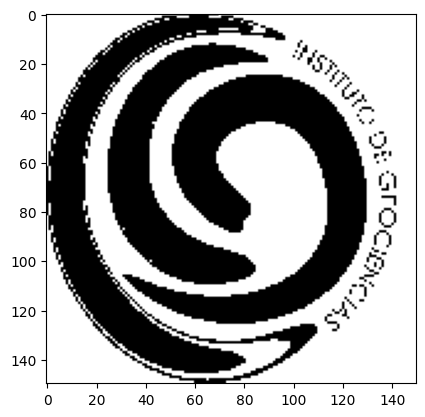

In [54]:
# Redimensionamos la imagen generada para que tenga las mismas dimensiones que la imagen original que deseamos reconstruir.
new_logo = np.resize(new_state,logo.shape)

# Visualizamos la imagen generada ya redimensionada, en escala de grises.
plt.imshow(new_logo,'gray')

In [55]:
# Comparamos cuantitativamente pixel a pixel la imagen reconstruida y la imagen original
compare(flat_logo, new_state)

100.0

En el caso de que la reconstrucción no sea perfecta, se puede aplicar una evolución más.

In [56]:
# Se ingreso nuevamente la imagen con ruido para re-entrenar la red neuronal
new_state2 = evolve(network,weights_matrix, new_state)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


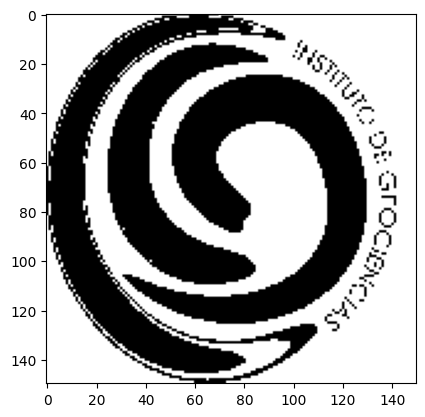

In [58]:
# Redimensionamos la imagen generada por la red neuronal para que tenga el mismo ancho y alto que la imagen original.
new_logo = np.resize(new_state2, logo.shape)

# Visualizamos la imagen generada ya redimensionada, en escala de grises.
plt.imshow(new_logo, 'gray')

# Imprimimos los valores de los pixeles de la imagen generada
print(new_logo)

Si la imagen finalmente está reconstruida, entonces podemos realizar la comparación con la original.

In [61]:
# Comparamos los valores de los pixeles de la imagen original con los de la imagen generada (ambas como vectores unidimensionales)
compare(flat_logo, new_state2)


100.0

Creamos otra imagen con doble ruido. Es decir, le agregamos ruido a la original y a la imagen con ruido, le agregamos otra vez ruido nuevamente.

[[ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 ...
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1 -1]]


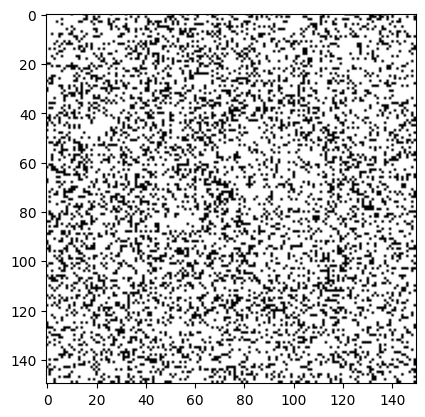

In [62]:
# Hacemos una copia de la imagen aplanada que le queremos agregar ruido
random_logo = flat_logo.copy()

# Le agregamos un ruido aleatorio
noise = bernoulli.rvs(0.7, size=len(random_logo))    

# Seleccionamos los pixeles cuyo valor sea 1 y les reasignamos el valor -1
random_logo[np.where(noise==1)] = -1

# Nuevamente le agregamos ruido aleatorio
noise = bernoulli.rvs(0.7, size=len(random_logo))

# Seleccionamos los pixeles cuyo valor sea 1, pero ahora les reasignamos el valor 1.
random_logo[np.where(noise==1)] = 1

# Redimensionamos la imagen aplanada con ruido para que tenga el mismo ancho y alto que la imagen original.
noise_logo = np.resize(random_logo,logo.shape)

# Imprimimos los valores de los pixeles de la imagen con ruido.
print(noise_logo)

# Visualizamos la imagen con ruido en escala de grises.
plt.imshow(noise_logo,'gray')

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


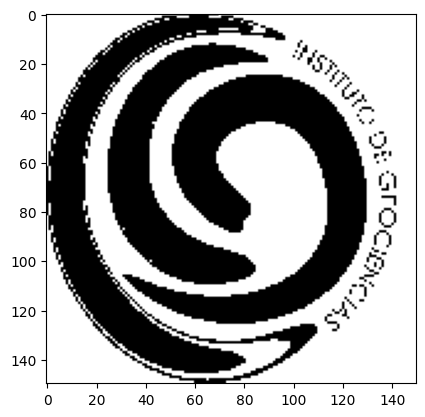

In [64]:
# Le pedimos a la red neuronal que evolucione para reconstruir la imagen original, a partir de la imagen con doble ruido.
random_logo = evolve(network, weights_matrix, random_logo)

# Redimensionamos la imagen generada para que tenga el mismo ancho y alto que la imagen original y poderla visualizar.
new_logo = np.resize(random_logo, logo.shape)

# Imprimimos los valores de los pixeles de la imagen generada con la red neuronal ya entrenada.
print(new_logo)

# Visualizamos la imagen generada en escala de grises.
plt.imshow(new_logo, 'gray')

In [73]:
compare(flat_logo,random_logo)

100.0

# Ejemplo donde la red neuronal no logra reconstruir la imagen original al 100%

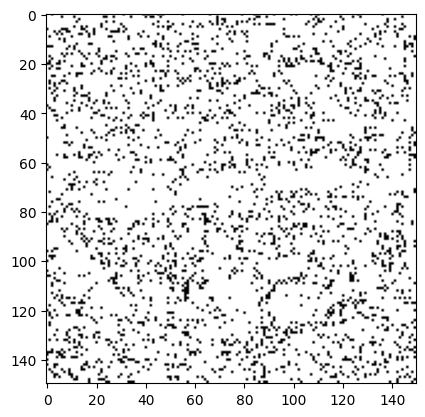

In [74]:
#creo una imagen con ruido
random_img = flat_img.copy()
noise = bernoulli.rvs(0.2, size=len(random_img))    
random_img[np.where(noise==1)]=-1
noise = bernoulli.rvs(0.8, size=len(random_img))    
random_img[np.where(noise==1)]=1

noise_img = np.resize(random_img,img.shape)
plt.imshow(noise_img,'gray')

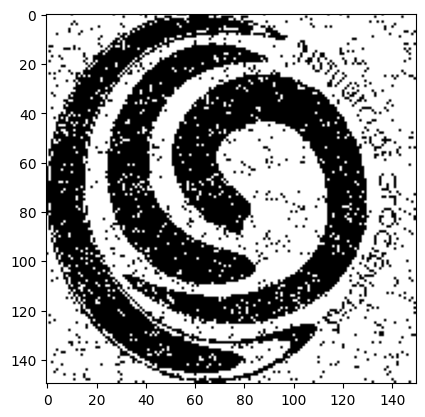

In [75]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')

In [76]:
compare(flat_img, random_img)

10.168888888888889

La red neuronal no reconstruyó la imagen al 100%

# Ejemplo donde la red neuronal se confunde de patrón aprendido

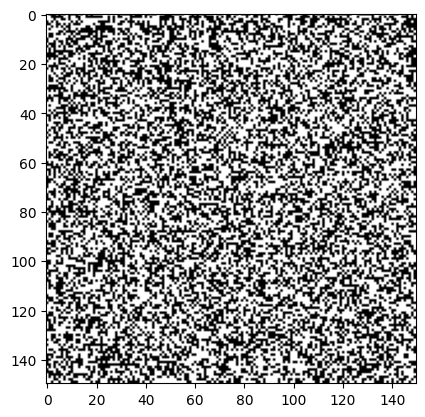

In [69]:
#creo una imagen con ruido
random_img = flat_img.copy()
noise = bernoulli.rvs(0.8, size=len(random_img))    
random_img[np.where(noise==1)]=-1
noise = bernoulli.rvs(0.5, size=len(random_img))    
random_img[np.where(noise==1)]=1

noise_img = np.resize(random_img,img.shape)
plt.imshow(noise_img,'gray')

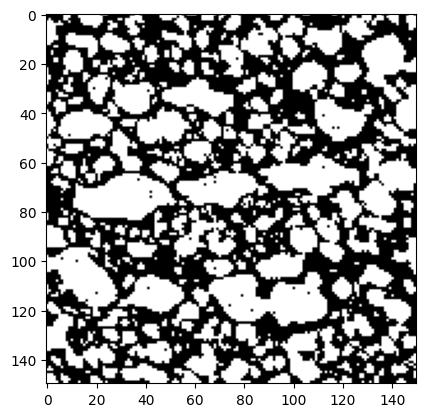

In [70]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')

Aquí la red cometió un error y reconstruyó el otro patrón de la imagen del medio poroso. Esto puede deberse a que la cantidad de conexiones es muy pobre. 

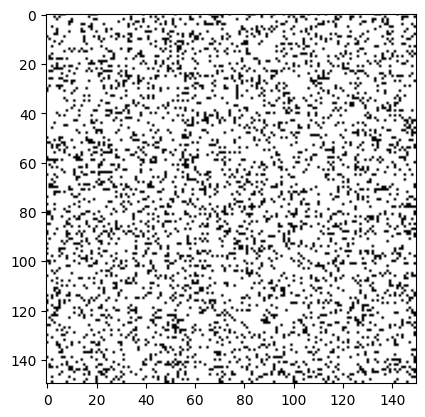

In [77]:
#creo una imagen con ruido
random_img = flat_img.copy()
noise = bernoulli.rvs(0.7, size=len(random_img))    
random_img[np.where(noise==1)]=-1
noise = bernoulli.rvs(0.8, size=len(random_img))    
random_img[np.where(noise==1)]=1

noise_img = np.resize(random_img,img.shape)
plt.imshow(noise_img,'gray')

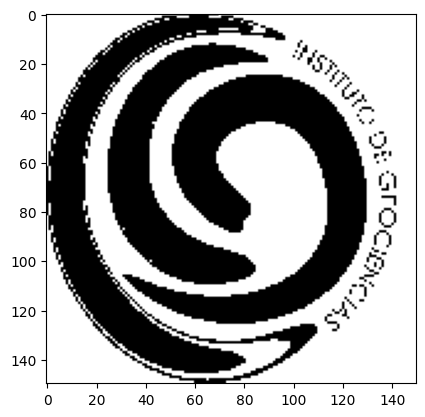

In [78]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')

En los ejemplos anteriores se muestra que se puede agregar bastante ruido a ambas imágenes y las reconstruirá, pero existe un límite de reconocimiento.

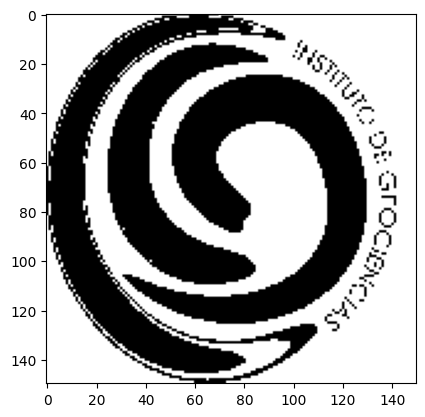

In [79]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')